In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import os
import glob
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle

# Data Preparation & Risk Scoring

In [2]:
SENSOR_DIR = "C:\\DumbStuff\\epf study\\Meta-Elasto\\els\\meta\\Elastography_rawdata\\oldcode\\"

def load_and_clean():
    df_pre = pd.read_csv("label-pre.csv"); df_pre['Time'] = 'PRE'
    df_post = pd.read_csv("label-post.csv"); df_post['Time'] = 'POST'
    df_fup = pd.read_csv("label-fup.csv"); df_fup['Time'] = 'FOLLOWUP'
    df_clinical = pd.concat([df_pre, df_post, df_fup], axis=0, ignore_index=True)

    # --- CALCULATE RISK FACTOR COUNT (0 to 5) ---
    def calculate_risk_score(row):
        score = 0
        try:
            if float(row['Glucose']) > 100: score += 1
            if float(row['Triglycerides']) > 150: score += 1
            if float(row['Blood_Pressure']) > 130: score += 1
            # HDL logic (0=Men, 1=Women)
            if (row['Sex'] == 0 and float(row['HDL_Cholestrol']) < 40) or \
               (row['Sex'] == 1 and float(row['HDL_Cholestrol']) < 50):
                score += 1
            # Waist logic
            if (row['Sex'] == 0 and float(row['Waist_Circum_mean']) > 94) or \
               (row['Sex'] == 1 and float(row['Waist_Circum_mean']) > 80):
                score += 1
        except: pass # Handle any NaNs in specific symptom columns
        return score

    df_clinical['Risk_Score'] = df_clinical.apply(calculate_risk_score, axis=1)

    df_mapping = pd.read_excel("meta/measured_with_elastograph_patients.xlsx")
    df_mapping.columns = df_mapping.columns.str.strip()
    df_master = pd.merge(df_mapping, df_clinical, on=['ID', 'Time'], how='inner')

    # FORCE NUMERIC: This solves the "numpy.object_" error
    meta_cols = ['Sex', 'Age', 'Waist_Circum_mean']
    for col in meta_cols:
        df_master[col] = pd.to_numeric(df_master[col], errors='coerce')
    
    df_master = df_master.dropna(subset=meta_cols + ['Risk_Score'])
    
    # Scaling
    scaler = StandardScaler()

    df_master[meta_cols] = scaler.fit_transform(df_master[meta_cols])
    return df_master, meta_cols, scaler


df_master, meta_cols, scaler = load_and_clean()

# Feature Encoder

In [3]:
class EncoderDataset(Dataset):
    def __init__(self, dataframe, sensor_dir, max_len=2000):
        self.dataframe = dataframe
        self.sensor_dir = sensor_dir
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        p_num_str = str(int(row['N_PACIENT'])).zfill(4)
        
        # Load Signal (18 Channels)
        files = glob.glob(os.path.join(self.sensor_dir, f"in_test_{p_num_str}_*.csv"))
        df_sig = pd.read_csv(files[0]) # Use first rep for feature extraction
        signal = df_sig.filter(regex='^F\d+').fillna(0).values.T
        
        # Crop/Pad
        if signal.shape[1] > self.max_len:
            signal = signal[:, :self.max_len]
        else:
            signal = np.pad(signal, ((0,0), (0, self.max_len - signal.shape[1])), 'constant')
            
        # Normalize Signal
        signal = (signal - np.mean(signal)) / (np.std(signal) + 1e-8)
        
        meta = row[meta_cols].values.astype(np.float32)
        score = row['Risk_Score']
        
        return torch.tensor(signal, dtype=torch.float32), torch.tensor(meta, dtype=torch.float32), score

<>:17: SyntaxWarning: invalid escape sequence '\d'
<>:17: SyntaxWarning: invalid escape sequence '\d'
C:\Users\ameyd\AppData\Local\Temp\ipykernel_27296\249469866.py:17: SyntaxWarning: invalid escape sequence '\d'
  signal = df_sig.filter(regex='^F\d+').fillna(0).values.T


# Architecture

In [4]:
class MultiModalEncoder(nn.Module):
    def __init__(self):
        super(MultiModalEncoder, self).__init__()
        
        # 1D-CNN for signals
        self.cnn_branch = nn.Sequential(
            nn.Conv1d(18, 32, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        
        # MLP for metadata
        self.mlp_branch = nn.Sequential(
            nn.Linear(3, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU()
        )

    def forward(self, signal, meta):
        sig_feat = self.cnn_branch(signal).squeeze(-1) # Output: 64
        meta_feat = self.mlp_branch(meta)               # Output: 16
        
        # Combine into one "Feature Vector"
        latent_vector = torch.cat((sig_feat, meta_feat), dim=1)
        return latent_vector

# Training

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Clustering is usually fine on CPU
dataset = EncoderDataset(df_master, SENSOR_DIR)
loader = DataLoader(dataset, batch_size=1, shuffle=False)

encoder = MultiModalEncoder()
encoder.eval()

latent_vectors = []
actual_scores = []

print("Extracting features...")
with torch.no_grad():
    for item in loader:
        if item is None: continue
        sig, meta, score = item
        feat = encoder(sig, meta)
        latent_vectors.append(feat.numpy().flatten().astype(np.float64))
        actual_scores.append(score.item())

X = np.array(latent_vectors).astype(np.float64)

Extracting features...


In [6]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

with open('meta_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Scaler saved")

✅ Scaler saved


In [7]:
# Save KMeans model
with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

# Visualization

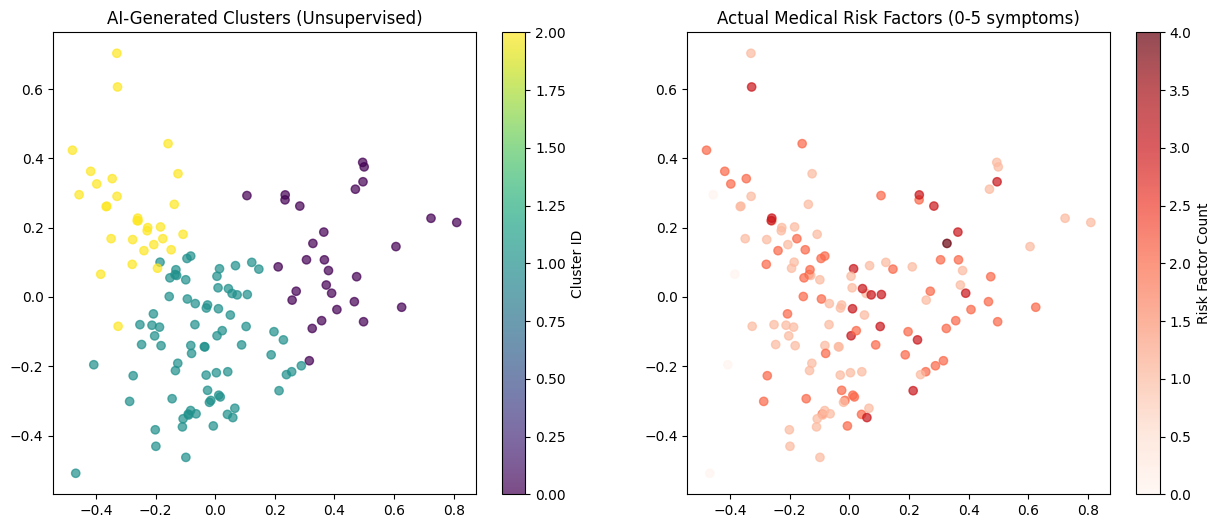

In [8]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: AI Clusters
sc1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.7)
ax1.set_title("AI-Generated Clusters (Unsupervised)")
plt.colorbar(sc1, ax=ax1, label='Cluster ID')

# Plot 2: Medical Risk Factors
sc2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=actual_scores, cmap='Reds', alpha=0.7)
ax2.set_title("Actual Medical Risk Factors (0-5 symptoms)")
plt.colorbar(sc2, ax=ax2, label='Risk Factor Count')

plt.show()

# Results

In [9]:
final_report = pd.DataFrame({'Cluster': clusters, 'Risk': actual_scores})
print("\n--- Correlation Check ---")
print(final_report.groupby('Cluster')['Risk'].describe()[['mean', 'std']])


--- Correlation Check ---
             mean       std
Cluster                    
0        1.896552  0.816999
1        1.578947  0.753006
2        1.433333  0.773854


AI Clustering Accuracy vs Medical Truth: 73.33%

--- Classification Report ---
                   precision    recall  f1-score   support

 Healthy/Low Risk       0.88      0.80      0.84       116
Metabolic Disease       0.21      0.32      0.25        19

         accuracy                           0.73       135
        macro avg       0.54      0.56      0.54       135
     weighted avg       0.78      0.73      0.76       135



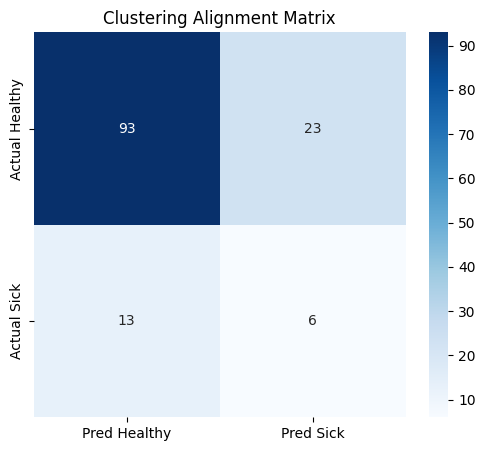

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# 1. Define Medical Ground Truth (Binarize the Risk Score)
# Risk Score >= 3 is "Sick" (1), < 3 is "Healthy" (0)
y_medical_truth = [1 if score >= 3 else 0 for score in actual_scores]

# 2. Map AI Clusters to Medical Labels
# We look at which cluster has the highest average risk score and call that 'Sick'
cluster_means = final_report.groupby('Cluster')['Risk'].mean()
sick_cluster = cluster_means.idxmax()
healthy_cluster = cluster_means.idxmin()

# Create predictions based on the mapping
y_ai_pred = []
for c in clusters:
    if c == sick_cluster:
        y_ai_pred.append(1)
    else:
        y_ai_pred.append(0)

# 3. Calculate Accuracy Score
accuracy = accuracy_score(y_medical_truth, y_ai_pred)
print(f"AI Clustering Accuracy vs Medical Truth: {accuracy*100:.2f}%")

# 4. Detailed Report
print("\n--- Classification Report ---")
print(classification_report(y_medical_truth, y_ai_pred, target_names=['Healthy/Low Risk', 'Metabolic Disease']))

# 5. Confusion Matrix Visualization
cm = confusion_matrix(y_medical_truth, y_ai_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Healthy', 'Pred Sick'], yticklabels=['Actual Healthy', 'Actual Sick'])
plt.title("Clustering Alignment Matrix")
plt.show()

In [11]:
torch.save(encoder.state_dict(), 'multi_modal_encoder.pth')
print("Model saved to 'multi_modal_encoder.pth'")

Model saved to 'multi_modal_encoder.pth'


In [12]:
import pickle
with open('meta_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Scaler saved")

✅ Scaler saved
